In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import plotly.graph_objs as go

In [2]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

In [3]:
def generate_hypergraph(num_vars, clauses, threshold):
    G = nx.Graph()

    for var in range(1, num_vars + 1):
        G.add_node(var)

    for i, clause in enumerate(clauses):
        G.add_nodes_from(map(abs, clause))
        for pair in itertools.combinations(map(abs, clause), 2):
            G.add_edge(*pair, clause=i + 1)

    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree <= threshold]
    G.remove_nodes_from(nodes_to_remove)

    return G

In [4]:
def draw_hypergraph(num_vars, clauses, threshold=0):
    G = generate_hypergraph(num_vars, clauses, threshold)
    pos = nx.spring_layout(G, seed=42)

    node_colors = [0] * (num_vars + 1)
    for node in G.nodes():
        for i, clause in enumerate(clauses):
            if abs(node) in map(abs, clause):
                node_colors[node] = i + 1
                break

    colors = [node_colors[node] for node in G.nodes()]

    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, font_size=10, node_color=colors, cmap=plt.cm.Blues, node_size=500, ax=ax)
    plt.show()

In [5]:
def draw_interactive_hypergraph(num_vars, clauses, threshold=0):
    G = generate_hypergraph(num_vars, clauses, threshold)
    pos = nx.spring_layout(G, seed=42)

    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            colorscale='Blues',
            reversescale=False,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Degree',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['text'] += ('Var: ' + str(node),)

    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color'] += (len(adjacencies[1]),)

    layout = go.Layout(
        titlefont=dict(size=16),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=5, l=5, r=5, t=5),
        annotations=[dict(
            text="",
            showarrow=False,
            xref="paper", yref="paper")],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    fig.show()

In [6]:
def update_threshold(threshold_value):
    clear_output(wait=True)
    draw_hypergraph(num_vars, clauses, threshold=threshold_value)
    draw_interactive_hypergraph(num_vars, clauses, threshold=threshold_value)

In [7]:
filename = "DIMACS_files/turbo_easy/example_2.cnf"
num_vars, clauses = read_dimacs_cnf(filename)

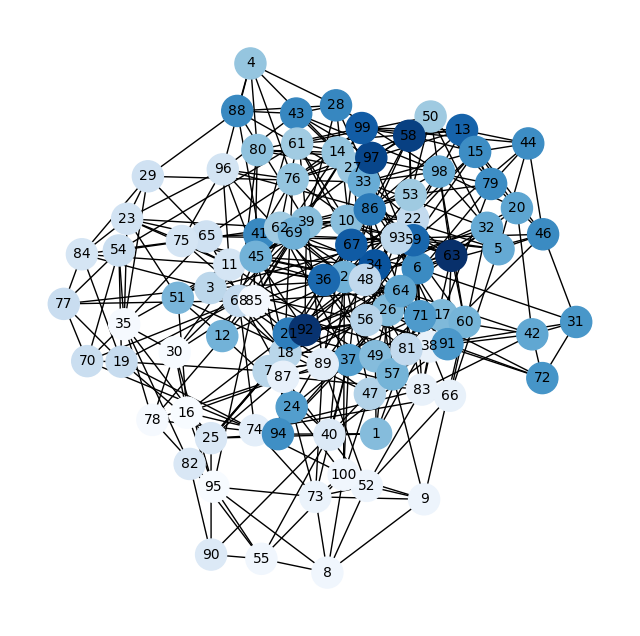

In [8]:
draw_hypergraph(num_vars, clauses, threshold=0)
draw_interactive_hypergraph(num_vars, clauses, threshold=0)

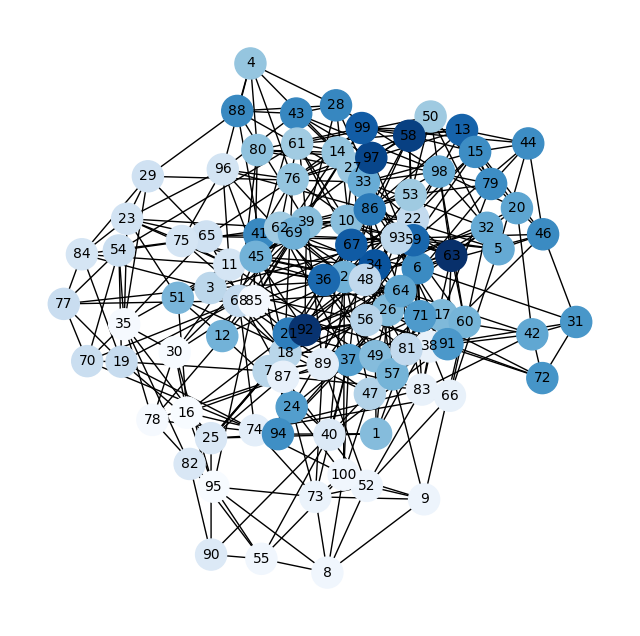

In [ ]:
threshold_slider = widgets.FloatSlider(value=0, min=0, max=10, step=1, description='Threshold:')
threshold_slider.observe(lambda change: update_threshold(change.new), names='value')

In [10]:
display(threshold_slider)

FloatSlider(value=0.0, description='Threshold:', max=10.0, step=1.0)